In [1]:
import numpy as np
from pathlib import Path

import xobjects as xo
import xtrack as xt
import xcoll as xc

import lossmaps as lm       # for plotting, get from https://gitlab.cern.ch/collteam/lossmaps

# Overall setup time (minus tracking):
#     ~70s with prebuilt kernels (almost only particle generation)
#     180s without (mainly losses interpolation)
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')     # no prebuilt kernels for OpenMP yet

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.


In [2]:
beam          = '1'
plane         = 'H'

# This takes  ~55s on CPU, 9s on OpenMP
num_turns     = 40
num_particles = int(1e5)

path_in  = Path.cwd()

In [3]:
# Load line from json
line = xt.Line.from_json(f'lhc_run3_b{beam}.json')

# Aperture model check
df_imported = line.check_aperture()
assert not np.any(df_imported.has_aperture_problem)

Loading line from dict:   0%|          | 0/102795 [00:00<?, ?it/s]

Done loading line from dict.           


Checking aperture:   0%|          | 0/102795 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


In [4]:
# Initialise collmanager
coll_manager = xc.CollimatorManager.from_yaml('collimators_simplified.yaml', line=line, beam=beam, _context=context)

In [5]:
# Install collimators into line
coll_manager.install_everest_collimators(verbose=True)

# Aperture model check after installing
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)

Installing tcp.6l3.b1           as EverestCollimator
Installing tcsg.5l3.b1          as EverestCollimator
Installing tcsg.4r3.b1          as EverestCollimator
Installing tctph.4l5.b1         as EverestCollimator
Installing tctpv.4l5.b1         as EverestCollimator
Installing tcp.d6l7.b1          as EverestCollimator
Installing tcp.c6l7.b1          as EverestCollimator
Installing tcsg.b5l7.b1         as EverestCollimator
Installing tcspm.b4l7.b1        as EverestCollimator
Installing tctph.4l1.b1         as EverestCollimator
Installing tctpv.4l1.b1         as EverestCollimator


Checking aperture:   0%|          | 0/102742 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


In [6]:
# Build the tracker
coll_manager.build_tracker()

Found suitable prebuilt kernel `default_xcoll`.


In [7]:
# Set the collimator openings based on the colldb,
# or manually override with the option gaps={collname: gap}
coll_manager.set_openings()

/Users/giadarol/xsuite_packages/xcoll/xcoll/manager.py:515: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.colldb._optics = pd.concat([


In [8]:
# Generate initial pencil distribution on horizontal collimator
tcp  = f"tcp.{'c' if plane=='H' else 'd'}6{'l' if beam=='1' else 'r'}7.b{beam}"
part = coll_manager.generate_pencil_on_collimator(tcp, num_particles=num_particles)

Collimator tcp.c6l7.b1 is converging.


In [9]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [10]:
# Track
coll_manager.enable_scattering()
line.track(part, num_turns=num_turns, time=True, with_progress=2)
coll_manager.disable_scattering()
print(f"Done tracking in {line.time_last_track:.1f}s.")

Tracking:   0%|          | 0/40 [00:00<?, ?it/s]

Done tracking in 71.3s.


In [11]:
line.discard_tracker()
line.build_tracker(_context=xo.context_default)

Found suitable prebuilt kernel `default_xcoll`.


In [12]:
# Save lossmap to json, which can be loaded, combined (for more statistics),
# and plotted with the 'lossmaps' package
output_file = f'lossmap_B{beam}{plane}.json'
coll_manager.lossmap(part, file=output_file)

# Need xtrack PR #456 to get all kernels prebuilt

# Show a summary of the collimator losses
coll_manager.summary(part)

Performing the aperture losses refinement.
Found suitable prebuilt kernel `default_xcoll`.
Found suitable prebuilt kernel `default_xcoll_no_limit`.
Found suitable prebuilt kernel `default_xcoll_backtrack_no_limit`.


,collname,nabs,length,s,type
0,tcp.6l3.b1,12.0,0.6,6487.671298,EverestCollimator
1,tcsg.5l3.b1,6.0,1.0,6520.992796,EverestCollimator
2,tcsg.4r3.b1,1.0,1.0,6707.575796,EverestCollimator
3,tctph.4l5.b1,18.0,1.0,13181.344217,EverestCollimator
4,tctpv.4l5.b1,6.0,1.0,13183.344216,EverestCollimator
5,tcp.d6l7.b1,1346.0,0.6,19789.184382,EverestCollimator
6,tcp.c6l7.b1,71250.0,0.6,19791.184382,EverestCollimator
7,tcsg.b5l7.b1,5299.0,1.0,19891.906380,EverestCollimator
8,tcspm.b4l7.b1,2323.0,1.0,19989.162380,EverestCollimator
9,tctph.4l1.b1,203.0,1.0,26510.938177,EverestCollimator


In [13]:
# Make a loss map instance for plotting amd load the data
ThisLM = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{beam}{plane}'], machine=lm.Machine.LHC, energy=6800, particle=lm.Particle.PROTON)
ThisLM.load_data_json(json_files=output_file)

Maximum inefficiency in the DS is 0.000494.


Warning, `show_layout` temporarily not supported.


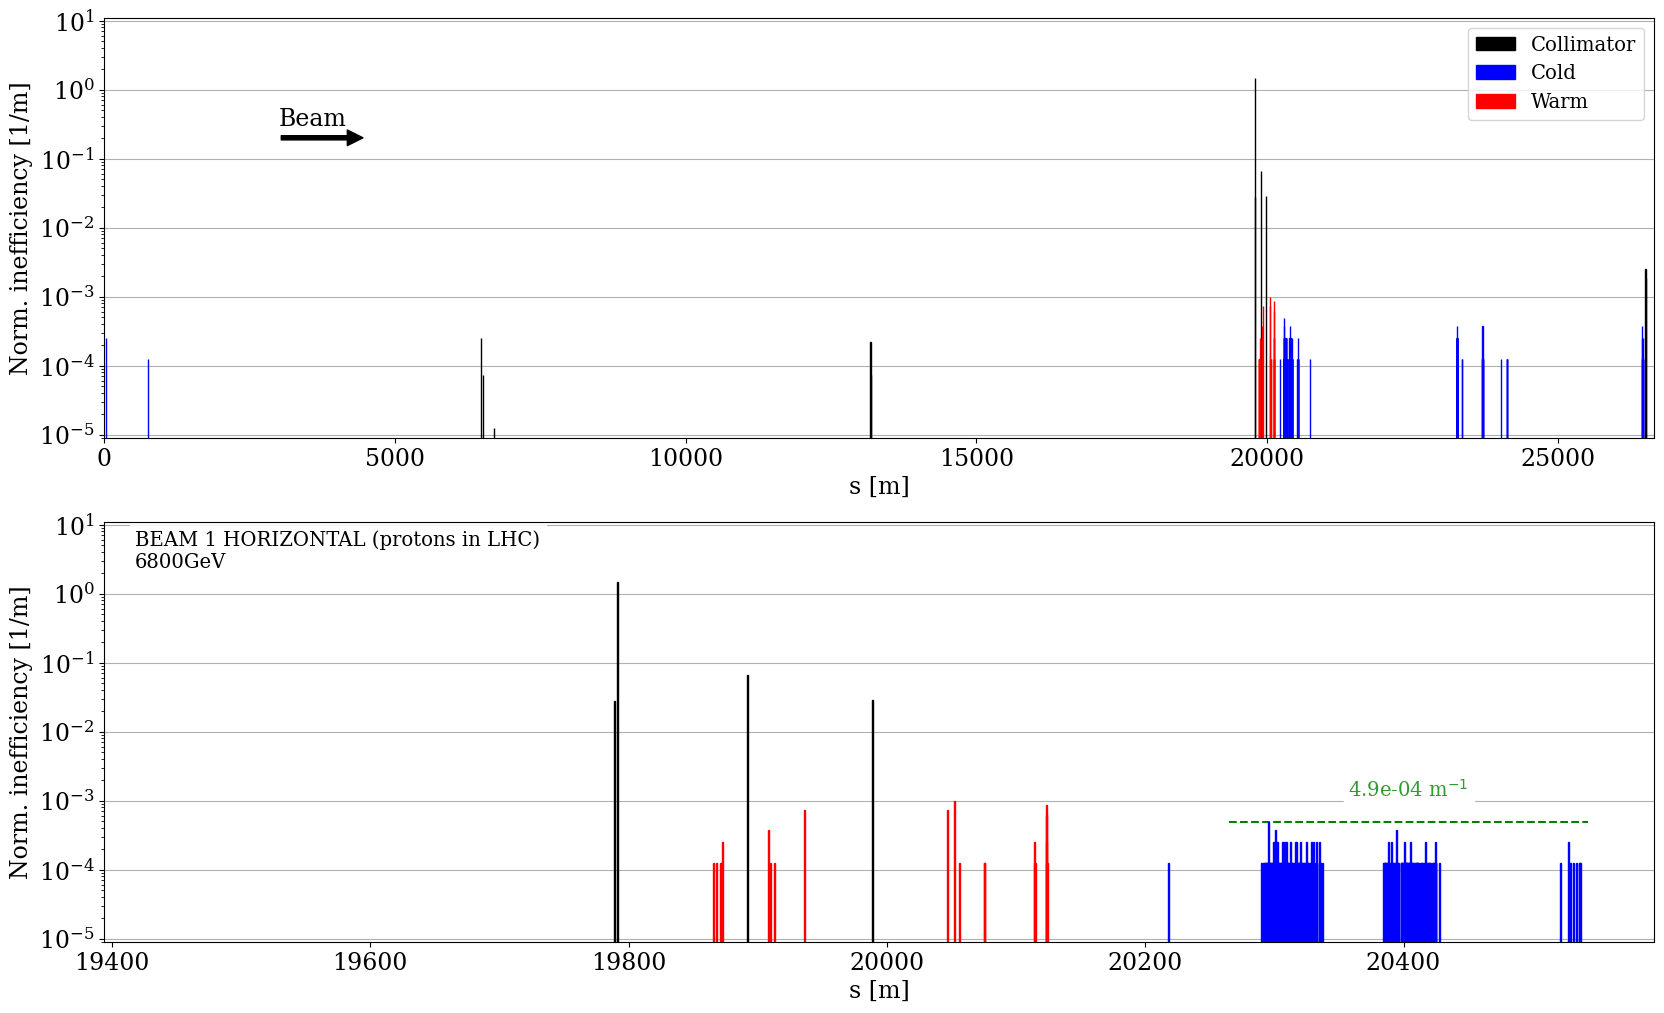

In [15]:
# Plot the loss map
_ = lm.plot_lossmap(ThisLM, outfile=None)